In [33]:
#imports
import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import fitz  # pymupdf
import pandas as pd
import re
import spacy
from tqdm.auto import tqdm
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM
import textwrap
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.utils import is_flash_attn_2_available 


In [2]:
nlp = spacy.load("de_core_news_sm")
# Add a sentencizer pipeline, see https://spacy.io/api/sentencizer/ 
nlp.add_pipe("sentencizer")
# Initialize the embedding model and move to the correct device
embedding_model = SentenceTransformer("all-mpnet-base-v2")
torch.cuda.empty_cache()
device = "cuda" if torch.cuda.is_available() else "cpu"



In [3]:
# Helper function to clean up text
def text_formatter(text: str) -> str:
    """Performs minor formatting on text."""
    cleaned_text = text.replace("\n", " ").strip() # note: this might be different for each doc (best to experiment)

    # Other potential text formatting functions can go here
    return cleaned_text
    
# PDF reading function
# Open PDF and get lines/pages
# Note: this only focuses on text, rather than images/figures etc
def open_and_read_pdf(pdf_path: str) -> list[dict]:
    """
    Opens a PDF file, reads its text content page by page, and collects statistics.

    Parameters:
        pdf_path (str): The file path to the PDF document to be opened and read.

    Returns:
        list[dict]: A list of dictionaries, each containing the page number
        (adjusted), character count, word count, sentence count, token count, and the extracted text
        for each page.
    """
    doc = fitz.open(pdf_path)  # open a document
    pages_and_texts = []
    for page_number, page in tqdm(enumerate(doc)):  # iterate the document pages
        text = page.get_text()  # get plain text encoded as UTF-8
        text = text_formatter(text)
        pages_and_texts.append({"page_number": page_number +1,  # adjust page numbers since our PDF starts on page 42
                                "page_char_count": len(text),
                                "page_word_count": len(text.split(" ")),
                                "page_sentence_count_raw": len(text.split(". ")),
                                "page_token_count": len(text) / 4,  # 1 token = ~4 chars, see: https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
                                "text": text})
    return pages_and_texts
    


pdf_path="Sicherung-des-Schienenverkehrs.pdf"
pages_and_texts = open_and_read_pdf(pdf_path)
df = pd.DataFrame(pages_and_texts)
df.head()
df.describe().round(2)

0it [00:00, ?it/s]

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,356.00,356.00,356.00,356.00,356.00
mean,178.50,2107.26,291.80,17.14,526.81
std,102.91,783.50,88.24,11.16,195.88
min,1.00,30.00,3.00,1.00,7.50
25%,89.75,1646.00,232.00,12.00,411.50
50%,178.50,2080.50,291.00,16.00,520.12
75%,267.25,2531.00,360.25,20.00,632.75
max,356.00,5711.00,563.00,97.00,1427.75


In [4]:
def sentesice_text(pages_and_texts):
    for item in tqdm(pages_and_texts):
        item["sentences"] = list(nlp(item["text"]).sents)
    
        # Make sure all sentences are strings
        item["sentences"] = [str(sentence) for sentence in item["sentences"]]
    
        # Count the sentences 
        item["page_sentence_count_spacy"] = len(item["sentences"])
    return pages_and_texts

sen_pages_and_texts = sentesice_text(pages_and_texts)
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)


  0%|          | 0/356 [00:00<?, ?it/s]

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,356.00,356.00,356.00,356.00,356.00,356.00
mean,178.50,2107.26,291.80,17.14,526.81,19.93
std,102.91,783.50,88.24,11.16,195.88,11.66
min,1.00,30.00,3.00,1.00,7.50,1.00
25%,89.75,1646.00,232.00,12.00,411.50,15.00
50%,178.50,2080.50,291.00,16.00,520.12,18.50
75%,267.25,2531.00,360.25,20.00,632.75,23.00
max,356.00,5711.00,563.00,97.00,1427.75,101.00


In [5]:
# Splitting function for sentence chunks
# Create a function that recursively splits a list into desired sizes
def split_list(input_list: list, 
               slice_size: int) -> list[list[str]]:
    """
    Splits the input_list into sublists of size slice_size (or as close as possible).

    For example, a list of 17 sentences would be split into two lists of [[10], [7]]
    """
    return [input_list[i:i + slice_size] for i in range(0, len(input_list), slice_size)]

def sentens_chunker(pages_and_texts):
    # Define split size to turn groups of sentences into chunks
    num_sentence_chunk_size = 10 

    for item in tqdm(pages_and_texts):
        item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                         slice_size=num_sentence_chunk_size)
        item["num_chunks"] = len(item["sentence_chunks"])
    return pages_and_texts
    
# Chunk preparation with embeddings
def prepare_chunks(pages_and_texts: list[dict], chunk_size=10):
    # Split each chunk into its own item
    pages_and_chunks = []
    sen_sentesice_text = sentesice_text(pages_and_texts)
    pages_and_texts = sentens_chunker(sen_pages_and_texts)
    for item in tqdm(pages_and_texts):
        for sentence_chunk in item["sentence_chunks"]:
            chunk_dict = {}
            chunk_dict["page_number"] = item["page_number"]
        
            # Join the sentences together into a paragraph-like structure, aka a chunk (so they are a single string)
            joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
            joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk) # ".A" -> ". A" for any full-stop/capital letter combo 
            chunk_dict["sentence_chunk"] = joined_sentence_chunk

            # Get stats about the chunk
            chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
            chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
            chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4 # 1 token = ~4 characters
        
            pages_and_chunks.append(chunk_dict)

    return pages_and_chunks
    
pages_and_chunks = prepare_chunks(sen_pages_and_texts)
len(pages_and_chunks)
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)


  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,872.00,872.00,872.00,872.00
mean,188.46,846.47,105.89,211.62
std,107.69,384.03,55.99,96.01
min,1.00,2.00,1.00,0.50
25%,97.00,548.75,59.00,137.19
50%,191.00,902.00,113.00,225.50
75%,282.25,1141.00,150.00,285.25
max,356.00,1897.00,306.00,474.25


In [6]:
# Main pipeline initialization
def initialize_pipeline(pdf_path: str):
    print("Loading PDF and processing text...")
    pages_and_texts = open_and_read_pdf(pdf_path)
    df = pd.DataFrame(pages_and_texts)
    # Get stats
    print(df.describe().round(2))
    print(df.head())    
    print("Preparing sentence chunks and embeddings...")
    pages_and_chunks = prepare_chunks(pages_and_texts)
    df1 = pd.DataFrame(pages_and_chunks)
    print(pages_and_chunks)
    print(df.describe().round(2))
    return pages_and_chunks

new_pages_and_chunks = initialize_pipeline(pdf_path)


Loading PDF and processing text...


0it [00:00, ?it/s]

       page_number  page_char_count  page_word_count  page_sentence_count_raw  \
count       356.00           356.00           356.00                   356.00   
mean        178.50          2107.26           291.80                    17.14   
std         102.91           783.50            88.24                    11.16   
min           1.00            30.00             3.00                     1.00   
25%          89.75          1646.00           232.00                    12.00   
50%         178.50          2080.50           291.00                    16.00   
75%         267.25          2531.00           360.25                    20.00   
max         356.00          5711.00           563.00                    97.00   

       page_token_count  
count            356.00  
mean             526.81  
std              195.88  
min                7.50  
25%              411.50  
50%              520.12  
75%              632.75  
max             1427.75  
   page_number  page_char_count  pag

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

  0%|          | 0/356 [00:00<?, ?it/s]

[{'page_number': 1, 'sentence_chunk': 'Sicherung des Schienenverkehrs Ulrich Maschek Grundlagen und Planung der Leit- und Sicherungstechnik 5. Auflage', 'chunk_char_count': 111, 'chunk_word_count': 14, 'chunk_token_count': 27.75}, {'page_number': 2, 'sentence_chunk': 'Sicherung des Schienenverkehrs', 'chunk_char_count': 30, 'chunk_word_count': 3, 'chunk_token_count': 7.5}, {'page_number': 3, 'sentence_chunk': 'Ulrich MaschekSicherung des Schienenverkehrs Grundlagen und Planung der Leit- und Sicherungstechnik5.,aktualisierte und erweiterte Auflage', 'chunk_char_count': 138, 'chunk_word_count': 14, 'chunk_token_count': 34.5}, {'page_number': 4, 'sentence_chunk': 'Ulrich MaschekTechnische Universität Dresden Dresden, DeutschlandISBN 978-3-658-37632-1ISBN 978-3-658-37633-8 (eBook)https://doi.org/10.1007/978-3-658-37633-8Die Deutsche Nationalbibliothek verzeichnet diese Publikation in der Deutschen Nationalbibliograﬁe;detaillierte bibliograﬁsche Daten sind im Internet über http://dnb.d-nb.d

In [7]:
def token_filter(new_pages_and_chunks):
    df = pd.DataFrame(new_pages_and_chunks)
    min_token_length = 30
    pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
    return pages_and_chunks_over_min_token_len
pages_and_chunks_over_min_token_len= token_filter(pages_and_chunks)


In [8]:
# Create the embeddings with a GPU
# Send the model to the GPU
embedding_model.to("cuda") # requires a GPU installed, for reference on my local machine, I'm using a NVIDIA RTX 4090
def embed_text(pages_and_chunks_over_min_token_len):
    # Create embeddings one by one on the GPU
    for item in tqdm(pages_and_chunks_over_min_token_len):
        item["embedding"] = embedding_model.encode(item["sentence_chunk"])
    # Turn text chunks into a single list
    text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]
    # Embed all texts in batches
    text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=32, # you can use different batch sizes here for speed/performance, I found 32 works well for this use case
                                               convert_to_tensor=True) # optional to return embeddings as tensor instead of array

    return text_chunk_embeddings

text_chunk_embeddings = embed_text(pages_and_chunks_over_min_token_len)


  0%|          | 0/841 [00:00<?, ?it/s]

In [9]:
# Save embeddings to file
def embed_text_save(pages_and_chunks_over_min_token_len):
    text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
    embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
    text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)
    return embeddings_df_save_path
embeddings_df_save_path = embed_text_save(pages_and_chunks_over_min_token_len)
text_chunks_and_embedding_df_load = pd.read_csv(embeddings_df_save_path)
text_chunks_and_embedding_df_load.head()


,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,3,Ulrich MaschekSicherung des Schienenverkehrs G...,138,14,34.50,[ 1.44595057e-02 -6.12595193e-02 -8.34962819e-...
1,4,Ulrich MaschekTechnische Universität Dresden D...,636,63,159.00,[ 3.27105857e-02 -7.40189627e-02 2.53605824e-...
2,4,"Das gilt insbesondere für Vervielfältigungen, ...",1250,156,312.50,[ 4.67061214e-02 -2.18969099e-02 2.64939815e-...
3,5,V Vorwort zur fünften Auflage Zehn Jahre nach...,1177,150,294.25,[ 3.78905013e-02 -5.35165742e-02 -5.97194489e-...
4,5,Neben kleinen Überarbeitungen in Formulierunge...,906,124,226.50,[-2.43437942e-02 -2.19610203e-02 -7.90196285e-...


In [10]:
# import our embeddings we created earlier (tk -link to embedding file) and prepare them for use by turning them into a tensor.
def embeddings_to_tensor(embeddings_df_save_path):
    # Import texts and embedding df
    text_chunks_and_embedding_df = pd.read_csv(embeddings_df_save_path)

    # Convert embedding column back to np.array (it got converted to string when it got saved to CSV)
    text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

    # Convert texts and embedding df to list of dicts
    pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")
    print(text_chunks_and_embedding_df.head())
    # Convert embeddings to torch tensor and send to device (note: NumPy arrays are float64, torch tensors are float32 by default)
    embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)
    return embeddings

embeddings = embeddings_to_tensor(embeddings_df_save_path)
embeddings.shape


   page_number                                     sentence_chunk  \
0            3  Ulrich MaschekSicherung des Schienenverkehrs G...   
1            4  Ulrich MaschekTechnische Universität Dresden D...   
2            4  Das gilt insbesondere für Vervielfältigungen, ...   
3            5  V  Vorwort zur fünften Auflage Zehn Jahre nach...   
4            5  Neben kleinen Überarbeitungen in Formulierunge...   

   chunk_char_count  chunk_word_count  chunk_token_count  \
0               138                14              34.50   
1               636                63             159.00   
2              1250               156             312.50   
3              1177               150             294.25   
4               906               124             226.50   

                                           embedding  
0  [0.0144595057, -0.0612595193, -0.000834962819,...  
1  [0.0327105857, -0.0740189627, 0.0253605824, -0...  
2  [0.0467061214, -0.0218969099, 0.0264939815, 0....  
3  [

torch.Size([841, 768])

In [11]:
query = "Linienförmige Zugbeeinflussung"
print(f"Query: {query}")

# Embed the query to the same numerical space as the text examples 
def query_topk(embeddings, query):
    # Note: It's important to embed your query with the same model you embedded your examples with.
    query_embedding = embedding_model.encode(query, convert_to_tensor=True)


    dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0]

    # Get the top-k results (we'll keep this to 5)
    top_results_dot_product = torch.topk(dot_scores, k=5)
    return top_results_dot_product

top_results_dot_product = query_topk(embeddings, query)
top_results_dot_product

Query: Linienförmige Zugbeeinflussung


torch.return_types.topk(
values=tensor([0.4930, 0.4862, 0.4859, 0.4832, 0.4788], device='cuda:0'),
indices=tensor([401,  76, 493, 601, 568], device='cuda:0'))

In [12]:
# Define helper function to print wrapped text 
def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

def outputer_result(query, embeddings):
    print(f"Query: '{query}'\n")
    print("Results:")
    # Loop through zipped together scores and indicies from torch.topk
    top_results_dot_product = query_topk(embeddings, query)
    for score, idx in zip(top_results_dot_product[0], top_results_dot_product[1]):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print("Text:")
        print_wrapped(pages_and_chunks[idx]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further (and check the results)
        print(f"Page number: {pages_and_chunks[idx]['page_number']}")
        print("\n")
    return pages_and_chunks[top_results_dot_product[1][0]]['page_number']
        
top_result = outputer_result(query, embeddings)
top_result

Query: 'Linienförmige Zugbeeinflussung'

Results:
Score: 0.4930
Text:
Während die Bezeichnung „Hebel“ bei mechanischen Stellwerken offensichtlich ist,
werden die hauptsächlichen Bedienelemente im elektromechani- schen Stellwerk
ebenfalls „Hebel“ genannt.
Page number: 175


Score: 0.4862
Text:
14 Sicherheit im Bahnbetrieb  Bild 2-5 Regelkreis nach Potthoff [PO58] Erweitert
man das Potthoffsche Modell gemäß Bild 2-6, so können damit alle grundlegenden
Aufgaben der Betriebssicherheit dargestellt und Komponenten und Systeme der
Sicherungstech- nik zugeordnet werden. Für die Fahrt in einem Gleisabschnitt
müssen der zugehörige Lichtraum frei sein sowie die dafür benötigten beweglichen
Fahrwegelemente die richtige Lage eingenommen haben. Die Ergän- zung um „Weitere
Elemente“ umfasst zusätzliche Voraussetzungen für eine gesicherte Fahrt, die
keine beweglichen Fahrwegelemente sind, wie z. B. die Bahnübergangssicherung
oder andere Besonderheiten. Ausgabe Stellbefehl Vorgabe GeschwindigkeitPrüfun

175

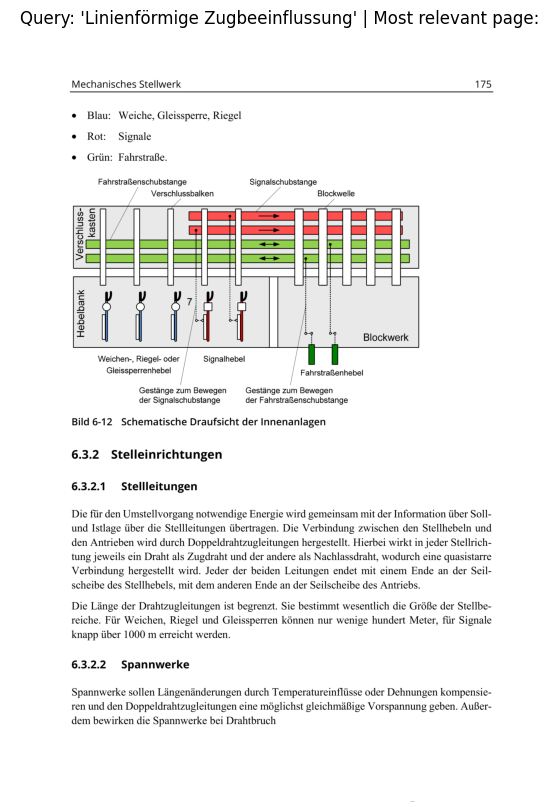

In [13]:
def get_page(pdf_path, top_result):
    doc = fitz.open(pdf_path)
    page = doc.load_page(11 + top_result) # number of page (our doc starts page numbers on page 1)

    # Get the image of the page
    img = page.get_pixmap(dpi=300)

    # Optional: save the image
    img.save("output_filename.png")
    doc.close()

    # Convert the Pixmap to a numpy array
    img_array = np.frombuffer(img.samples_mv, 
                              dtype=np.uint8).reshape((img.h, img.w, img.n))
    return img_array
# Display the image using Matplotlib
def plt_best_res(img_array, query):
    plt.figure(figsize=(13, 10))
    plt.imshow(img_array)
    plt.title(f"Query: '{query}' | Relevante Seite:")
    plt.axis('off') # Turn off axis
    plt.show()

img_array = get_page(pdf_path, top_result)
plt_best_res(img_array, query)

In [19]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5,
                                print_time: bool=True):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # Embed the query
    query_embedding = model.encode(query, 
                                   convert_to_tensor=True) 

    # Get dot product scores on embeddings
    
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    
    scores, indices = torch.topk(input=dot_scores, 
                                 k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
    """
    Takes a query, retrieves most relevant resources and prints them out in descending order.

    Note: Requires pages_and_chunks to be formatted in a specific way (see above for reference).
    """
    
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings,
                                                  n_resources_to_return=n_resources_to_return)
    
    print(f"Query: {query}\n")
    print("Results:")
    # Loop through zipped together scores and indicies
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        # Print the page number too so we can reference the textbook further and check the results
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")


In [62]:
query = "Was ist Zugbeitflusung und welche Systeme gibt es da?"

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)

scores, indices

(tensor([0.5882, 0.5830, 0.5572, 0.5492, 0.5422], device='cuda:0'),
 tensor([ 47,  83, 568,  76, 534], device='cuda:0'))

In [24]:
print_top_results_and_scores(query=query,
                             embeddings=embeddings)

Query: Flankenschutztabelle

Results:
Score: 0.5366
muss die Fahrstraßenzugschlussstelle berücksichtigt werden, damit beim Verbleib
eines Zuges im Zielgleis der befahrene Teil aufgelöst werden kann. Ebenso müssen
der Durch- rutschweg bis zu seinem Ende sowie die Flankenschutzräume
freigemeldet werden. Trennung der Freimeldung von Teilfahrstraßenknoten Ein
Teilfahrstraßenknoten ist definiert als ein Element eines Fahrstraßenknotens, in
dem sich alle darüber führenden Fahrstraßen gegenseitig ausschließen. Somit
besteht ein Teilfahrstraßen- knoten aus einer oder mehreren Weichen und / oder
Kreuzungen und ist dadurch gekennzeichnet, dass über ihn immer nur eine Fahrt
zur gleichen Zeit stattfinden kann. Liegt eine Konstellation vor, bei der über
diese Weichen bzw. Kreuzungen mehrere Fahrten stattfinden können, so han- delt
es sich um mehr als einen Teilfahrstraßenknoten. In Bild 10-26a) ist zu
erkennen, dass es sich hier um zwei Teilfahrstraßenknoten handelt, da auf dem
oberen und dem unter

In [29]:
# Get GPU available memory
def get_meno_GPU():
    gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
    gpu_memory_gb = round(gpu_memory_bytes / (2**30))
    print(f"Available GPU memory: {gpu_memory_gb} GB")
    return gpu_memory_gb

In [38]:
# Note: the following is Gemma focused, however, there are more and more LLMs of the 2B and 7B size appearing for local use.
def des_llm_from_gpu():
    gpu_memory_gb = get_meno_GPU()
    if gpu_memory_gb < 5.1:
        print(f"Your available GPU memory is {gpu_memory_gb}GB, you may not have enough memory to run a Gemma LLM locally without quantization.")
    elif gpu_memory_gb < 8.1:
        print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in 4-bit precision.")
        use_quantization_config = True 
        model_id = "google/gemma-2-2b-it"
    elif gpu_memory_gb < 19.0:
        print(f"GPU memory: {gpu_memory_gb} | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.")
        use_quantization_config = False 
        model_id = "google/gemma-2-2b-it"
    elif gpu_memory_gb > 19.0:
        print(f"GPU memory: {gpu_memory_gb} | Recommend model: Gemma 7B in 4-bit or float16 precision.")
        use_quantization_config = False 
        model_id = "google/gemma-7b-it"

    print(f"use_quantization_config set to: {use_quantization_config}")
    print(f"model_id set to: {model_id}")
    return model_id, use_quantization_config
    

Available GPU memory: 16 GB
GPU memory: 16 | Recommended model: Gemma 2B in float16 or Gemma 7B in 4-bit precision.
use_quantization_config set to: False
model_id set to: google/gemma-2-2b-it


In [41]:
def get_llm_ger():
    model_id , use_quantization_config = des_llm_from_gpu()
    # 1. Create quantization config for smaller model loading (optional)
    # Requires !pip install bitsandbytes accelerate, see: https://github.com/TimDettmers/bitsandbytes, https://huggingface.co/docs/accelerate/
    # For models that require 4-bit quantization (use this if you have low GPU memory available)
    from transformers import BitsAndBytesConfig
    quantization_config = BitsAndBytesConfig(load_in_4bit=True,
                                             bnb_4bit_compute_dtype=torch.float16)
    # Bonus: Setup Flash Attention 2 for faster inference, default to "sdpa" or "scaled dot product attention" if it's not available
    # Flash Attention 2 requires NVIDIA GPU compute capability of 8.0 or above, see: https://developer.nvidia.com/cuda-gpus
    # Requires !pip install flash-attn, see: https://github.com/Dao-AILab/flash-attention 
    if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
      attn_implementation = "flash_attention_2"
    else:
      attn_implementation = "sdpa"
    print(f"[INFO] Using attention implementation: {attn_implementation}")
    
    # 2. Pick a model we'd like to use (this will depend on how much GPU memory you have available)
    #model_id = "google/gemma-7b-it"
    model_id = model_id # (we already set this above)
    print(f"[INFO] Using model_id: {model_id}")
    
    # 3. Instantiate tokenizer (tokenizer turns text into numbers ready for the model) 
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_id)
    
    # 4. Instantiate the model
    llm_model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id, 
                                                     torch_dtype=torch.float16, # datatype to use, we want float16
                                                     quantization_config=quantization_config if use_quantization_config else None,
                                                     low_cpu_mem_usage=False, # use full memory 
                                                     attn_implementation=attn_implementation) # which attention version to use
    
    if not use_quantization_config: # quantization takes care of device setting automatically, so if it's not used, send model to GPU 
        llm_model.to("cuda")
    return tokenizer llm_model


SyntaxError: expected ':' (1933401860.py, line 1)

In [42]:
if llm_model is None: llm_model = get_llm_ger()

In [43]:
llm_model 

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNorm((2304,),

In [45]:
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(llm_model)

2614341888

In [46]:
def get_model_mem_size(model: torch.nn.Module):
    """
    Get how much memory a PyTorch model takes up.

    See: https://discuss.pytorch.org/t/gpu-memory-that-model-uses/56822
    """
    # Get model parameters and buffer sizes
    mem_params = sum([param.nelement() * param.element_size() for param in model.parameters()])
    mem_buffers = sum([buf.nelement() * buf.element_size() for buf in model.buffers()])

    # Calculate various model sizes
    model_mem_bytes = mem_params + mem_buffers # in bytes
    model_mem_mb = model_mem_bytes / (1024**2) # in megabytes
    model_mem_gb = model_mem_bytes / (1024**3) # in gigabytes

    return {"model_mem_bytes": model_mem_bytes,
            "model_mem_mb": round(model_mem_mb, 2),
            "model_mem_gb": round(model_mem_gb, 2)}

get_model_mem_size(llm_model)


{'model_mem_bytes': 5228697088, 'model_mem_mb': 4986.47, 'model_mem_gb': 4.87}

In [52]:
input_text = "Was ist Zugbeiflussung im Schienenverkehr"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")
# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
# See generate docs: https://huggingface.co/docs/transformers/v4.38.2/en/main_classes/text_generation#transformers.GenerationConfig 
outputs = llm_model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Input text:
Was ist Zugbeiflussung im Schienenverkehr

Prompt (formatted):
<bos><start_of_turn>user
Was ist Zugbeiflussung im Schienenverkehr<end_of_turn>
<start_of_turn>model

Model input (tokenized):
{'input_ids': tensor([[    2,     2,   106,  1645,   108, 11576,  2641, 40008,   555,   648,
         21965,  1063,  1485,  2415, 47329, 75822,   107,   108,   106,  2516,
           108]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}

Model output (tokens):
tensor([     2,      2,    106,   1645,    108,  11576,   2641,  40008,    555,
           648,  21965,   1063,   1485,   2415,  47329,  75822,    107,    108,
           106,   2516,    108,   1620,  40008,    555,    648,  21965,   1063,
          1485,   2415,  47329,  75822,    109,    688, 140490,    555,    648,
         21965,   1063,    688,   2641,   1783,  87648, 235269,   1188,   1303,
          5231, 106421,  37084,   2232,  92548,  

In [53]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")


Model output (decoded):
<bos><bos><start_of_turn>user
Was ist Zugbeiflussung im Schienenverkehr<end_of_turn>
<start_of_turn>model
## Zugbeiflussung im Schienenverkehr

**Zugbeiflussung** ist ein Begriff, der die **Zusammenführung von mehreren Zugfahrten in einem bestimmten Abschnitt der Gleisstrecke beschreibt**. 

**Ziel der Zugbeiflussung:**

* **Effizienzsteigerung:** Durch die Verlagerung von Fahrten in einen bestimmten Abschnitt der Strecke kann die Gesamtzeit für die Zugfahrt verkürzt werden.
* **Verbesserung der Betriebssicherheit:** Durch die gezielte Steuerung der Zugbeiflussung kann die Gefahr von Unfällen minimiert werden.
* **Optimierung der Kapazität:** Durch die Verlagerung von Fahrten kann die Kapazität der Strecke erhöht werden.

**Wie funktioniert Zugbeiflussung?**

* **Zugbeiflussung kann durch verschiedene Mechanismen erreicht werden:**
    * **Gleiswechsel:** Zugfahrten werden in einem bestimmten Abschnitt der Strecke geteilt und fahren auf unterschiedlichen Gleisen

In [54]:
print(f"Query: {query}")

# Get just the scores and indices of top related results
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
scores, indices


Query: Flankenschutztabelle


(tensor([0.5366, 0.5267, 0.5150, 0.4972, 0.4927], device='cuda:0'),
 tensor([738, 283, 739, 733, 808], device='cuda:0'))

In [59]:
def prompt_formatter(query: str, 
                     context_items: list[dict]) -> str:
    """
    Augments query with text-based context from context_items.
    """
    # Join context items into one dotted paragraph
    context = "- " + "\n- ".join([item["sentence_chunk"] for item in context_items])

    # Create a base prompt with examples to help the model
    # Note: this is very customizable, I've chosen to use 3 examples of the answer style we'd like.
    # We could also write this in a txt file and import it in if we wanted.
    base_prompt = """Beantworte bitte die Frage anhand der folgenden Kontextinformationen. 
Lassen dir sich Zeit zum Nachdenken, indem du die relevante Passagen aus dem Kontext nimmst, bevor du die Frage beantwortest. 
Geben nicht die Gedanken wieder, sondern nur die Antwort. 
Achten darauf, dass deine Antworten die Frage so weit wie möglich erklären. 
\Verwende nun die folgenden Kontextelemente, um die Benutzeranfrage zu beantworten:
{context}
\nRelevant Kontextelemente: <extract relevant passages from the context here>
User query: {query}
"""

    # Update base prompt with context items and query   
    base_prompt = base_prompt.format(context=context, query=query)

    # Create prompt template for instruction-tuned model
    dialogue_template = [
        {"role": "user",
        "content": base_prompt}
    ]

    # Apply the chat template
    prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                          tokenize=False,
                                          add_generation_prompt=True)
    return prompt


In [60]:
# Get relevant resources
scores, indices = retrieve_relevant_resources(query=query,
                                              embeddings=embeddings)
    
# Create a list of context items
context_items = [pages_and_chunks[i] for i in indices]

# Format prompt with context items
prompt = prompt_formatter(query=query,
                          context_items=context_items)
print(prompt)


<bos><start_of_turn>user
Beantworte bitte die Frage anhand der folgenden Kontextinformationen. 
Lassen dir sich Zeit zum Nachdenken, indem du die relevante Passagen aus dem Kontext nimmst, bevor du die Frage beantwortest. 
Geben nicht die Gedanken wieder, sondern nur die Antwort. 
Achten darauf, dass deine Antworten die Frage so weit wie möglich erklären. 
\Verwende nun die folgenden Kontextelemente, um die Benutzeranfrage zu beantworten:
- muss die Fahrstraßenzugschlussstelle berücksichtigt werden, damit beim Verbleib eines Zuges im Zielgleis der befahrene Teil aufgelöst werden kann. Ebenso müssen der Durch- rutschweg bis zu seinem Ende sowie die Flankenschutzräume freigemeldet werden. Trennung der Freimeldung von Teilfahrstraßenknoten Ein Teilfahrstraßenknoten ist definiert als ein Element eines Fahrstraßenknotens, in dem sich alle darüber führenden Fahrstraßen gegenseitig ausschließen. Somit besteht ein Teilfahrstraßen- knoten aus einer oder mehreren Weichen und / oder Kreuzungen un

In [63]:
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

# Generate an output of tokens
outputs = llm_model.generate(**input_ids,
                             temperature=0.7, # lower temperature = more deterministic outputs, higher temperature = more creative outputs
                             do_sample=True, # whether or not to use sampling, see https://huyenchip.com/2024/01/16/sampling.html for more
                             max_new_tokens=256) # how many new tokens to generate from prompt 

# Turn the output tokens into text
output_text = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"RAG answer:\n{output_text.replace(prompt, '')}")


Query: Was ist Zugbeitflusung und welche Systeme gibt es da?
RAG answer:
<bos>Die Flankenschutzräume müssen freigemeldet werden, wenn der Zug in der Fahrstraßenzugschlussstelle bleibt. 
<end_of_turn>


In [64]:
def ask(query, 
        temperature=0.7,
        max_new_tokens=512,
        format_answer_text=True, 
        return_answer_only=True):
    """
    Takes a query, finds relevant resources/context and generates an answer to the query based on the relevant resources.
    """
    
    # Get just the scores and indices of top related results
    scores, indices = retrieve_relevant_resources(query=query,
                                                  embeddings=embeddings)
    
    # Create a list of context items
    context_items = [pages_and_chunks[i] for i in indices]

    # Add score to context item
    for i, item in enumerate(context_items):
        item["score"] = scores[i].cpu() # return score back to CPU 
        
    # Format the prompt with context items
    prompt = prompt_formatter(query=query,
                              context_items=context_items)
    
    # Tokenize the prompt
    input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate an output of tokens
    outputs = llm_model.generate(**input_ids,
                                 temperature=temperature,
                                 do_sample=True,
                                 max_new_tokens=max_new_tokens)
    
    # Turn the output tokens into text
    output_text = tokenizer.decode(outputs[0])

    if format_answer_text:
        # Replace special tokens and unnecessary help message
        output_text = output_text.replace(prompt, "").replace("<bos>", "").replace("<eos>", "").replace("Sure, here is the answer to the user query:\n\n", "")

    # Only return the answer without the context items
    if return_answer_only:
        return output_text
    
    return output_text, context_items


In [65]:
print(f"Query: {query}")

# Answer query with context and return context 
answer, context_items = ask(query=query, 
                            temperature=0.7,
                            max_new_tokens=512,
                            return_answer_only=False)


Query: Was ist Zugbeitflusung und welche Systeme gibt es da?


In [66]:
print(f"Answer:\n")
print_wrapped(answer)
print(f"Context items:")
context_items


Answer:

Zugbeeinflussung ist eine Technik, die die Steuerung und Überwachung der
Geschwindigkeit und dem Zugverkehr auf der Eisenbahnstrecke ermöglicht.
Folgende Systeme sind relevant:  * **PZB (Positive Zugbeeinflussung)**: Ein
System zur Sicherung von Bahnanlagen durch Erkennung und Reaktion auf
Zugbewegungen. Es kann  verschiedene Fehlerarten erkennen (z.B. Ausfall des
Gleismagneten) und entsprechende Maßnahmen ergreifen. * **Festdatenbalisen:**
In der Regel an Haupt- und Vorsignalen angebracht, dienen sie zur Übertragung
der Movement Authority (MA) und zur Steuerung der Zugfahrt. *
**Transparentdatenbalisen:**  Sind an den virtuellen Standorten von Haupt- und
Vorsignalen angebracht. Sie dienen zur Aktualisierung der MA und ermöglichen
eine kontinuierliche Übertragung von Informationen. * **Euroloop:**  Eine
Technologie zur Datenübertragung in einer Linienform. * **Infill-Balisen:**
Zusätzliche Möglichkeiten zur punktförmigen Übertragung von Daten.
<end_of_turn>
Context items:


[{'page_number': 17,
  'sentence_chunk': '328 10.8.2 Anwendung an Haupt-, Vor- und Sperrsignalen ............................................329 10.8.3 Überwachung der signalisierten Geschwindigkeit .........................................332 10.9 Digitale LST-Planung................................................................................................334 10.9.1 Motivation ......................................................................................................334 10.9.2 Entwicklung der Informationsmodelle ...........................................................335 10.9.3Das Projekt „PlanPro“ ....................................................................................336 10.9.4 Stand und Ausblick ........................................................................................338 Literaturverzeichnis ..............................................................................................................339 Sachwortverzeichnis ............